In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
num_timesteps = 6
vocab_size = 100
embedding_dim = 16

In [4]:
offdiag_precision = -10.0 * np.ones((num_timesteps -1,))
precision_matrix = np.diag(offdiag_precision, 1) + np.diag(offdiag_precision, -1)
precision_matrix -= np.diag(np.sum(precision_matrix, axis=0))
precision_matrix += np.diag(np.ones((num_timesteps,)))
precision_matrix

array([[ 11., -10.,   0.,   0.,   0.,   0.],
       [-10.,  21., -10.,   0.,   0.,   0.],
       [  0., -10.,  21., -10.,   0.,   0.],
       [  0.,   0., -10.,  21., -10.,   0.],
       [  0.,   0.,   0., -10.,  21., -10.],
       [  0.,   0.,   0.,   0., -10.,  11.]])

In [5]:
chol_cov = np.linalg.inv(np.linalg.cholesky(precision_matrix)).T
chol_cov

array([[0.30151134, 0.26343168, 0.21502592, 0.16756809, 0.12689684,
        0.18547679],
       [0.        , 0.28977485, 0.23652851, 0.1843249 , 0.13958653,
        0.20402447],
       [0.        , 0.        , 0.28168396, 0.2195142 , 0.16623486,
        0.24297459],
       [0.        , 0.        , 0.        , 0.27665492, 0.20950669,
        0.30622217],
       [0.        , 0.        , 0.        , 0.        , 0.27372918,
        0.40009198],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.53397098]])

In [6]:
np.allclose(chol_cov.dot(chol_cov.T), np.linalg.inv(precision_matrix))

True

```
E[eps.T chol_cov.T chol_cov eps] =
E[chol_cov eps eps.T chol_cov.T] =
chol_cov E[eps eps.T] chol_cov.T =
chol_cov chol_cov.T =
cov
```

In [7]:
np.random.seed(1234)
eps = np.random.normal(size=(vocab_size*embedding_dim, num_timesteps))
emb = chol_cov.dot(eps.T).reshape((num_timesteps, vocab_size, embedding_dim))
emb.shape

(6, 100, 16)

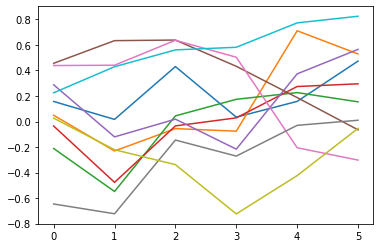

In [8]:
plt.figure()
for i in range(10):
    plt.plot(emb[:,0,i]);

In [10]:
max_abs = np.abs(emb).max()
scaling = 127.5 / max_abs
quantized = np.clip(np.round(scaling * emb), -127, 127).astype(np.int8)

In [11]:
# quantized.tofile('random_%d_%d_%d' % quantized.shape)

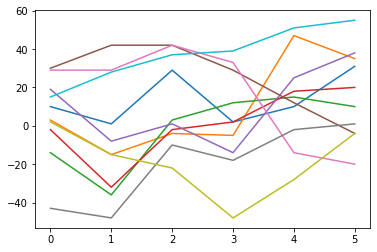

In [12]:
plt.figure()
for i in range(10):
    plt.plot(quantized[:,0,i]);

In [70]:
1 / scaling**2

0.00022723492425021167

In [15]:
quantized[3, 5, 15]

-1

In [17]:
quantized[0, 40,8]

13

In [66]:
quantized[-1, 0, 13]

5

In [20]:
quantized.shape

(6, 100, 16)

In [ ]:
0 1 2 3 4 5
x         x

In [44]:
def integer_div_toward_zero(numerand, divisor):
    return np.sign(numerand) * np.sign(divisor) * (np.abs(numerand) // np.abs(divisor))

In [60]:
def diff(i):
    return quantized[2, i, :].astype(np.int16) - integer_div_toward_zero(quantized[0, i, :].astype(np.int16) + quantized[-1, i, :].astype(np.int16), 2)

In [90]:
quantized[2, 1, :]

array([-15,  13,  -1,  -7, -19,  28,   6,   3,  64,  -8, -18,  -3, -40,
        49,  -3, -36], dtype=int8)

In [87]:
diff(1)

array([-20,   9, -15,  -7, -11,  22, -55,  23,  -9,  -3,  26,   6, -21,
         6,  57,   5], dtype=int16)

In [62]:
diff(5)

array([  2, -23,  14,  42,   3,  31,   6, -20, -23,  10,  21,   3, -19,
         2,  34,  -3], dtype=int16)

In [63]:
diff(8)

array([ 10,  -9,   0,  20,  13,  26,  33, -21,  18,  14, -32,  13,  18,
        -5,  -5,   4], dtype=int16)

In [64]:
diff(9)

array([-19, -22,   3,  29,  12,   2, -18, -18, -34, -24,  21, -24,  15,
       -31, -25,  13], dtype=int16)

In [86]:
words1 = [3, 50, 1]
words2 = [70, 3, 12]

[(1 / scaling**2) * np.sum(quantized[:, w1, :].astype(np.int32) * quantized[:, w2, :].astype(np.int32), axis=1)
 for w1, w2 in zip(words1, words2)]

[array([ 0.47492099, -0.53468378, -1.49157004, -1.54996942, -1.03687296,
         0.2576844 ]),
 array([0.57104136, 0.09180291, 1.60768709, 1.78947503, 0.37198357,
        1.15662576]),
 array([ 0.41561268, -0.10225572,  0.22655322,  0.67443326,  0.4528792 ,
        -0.74646673])]

In [74]:
unique_words = [1, 3, 12, 50, 70]

In [84]:
quantized[0, 3, :]

array([ 13,   2,  33,  18,  24,   0,   8,  11,  43,  -9,  -7,  22,  80,
       -52, -58,  32], dtype=int8)

In [85]:
quantized[0, 70, :]

array([ -5,  21,  41,  44,  14, -15, -19,  15,   7, -11,  11, -45, -32,
        55, -57,  75], dtype=int8)

In [83]:
quantized[0, 70, :].dot(quantized[0, 3, :])

42

In [77]:
[quantized[0, w, :] for w in unique_words]

[array([ -9,  25,   1, -13, -30,   7,  54, -11,  63,  18, -62, -25,   6,
         36, -69, -62], dtype=int8),
 array([ 13,   2,  33,  18,  24,   0,   8,  11,  43,  -9,  -7,  22,  80,
        -52, -58,  32], dtype=int8),
 array([-42, -14,   9,  49,  15,  53,  -8, -62, -25,  95,  15,   6,  -5,
         47,  19, -46], dtype=int8),
 array([ 37,   8,  -9,  21,   0, -19, -28, -18, -30,  18, -25,   9,   0,
         -9, -28,  42], dtype=int8),
 array([ -5,  21,  41,  44,  14, -15, -19,  15,   7, -11,  11, -45, -32,
         55, -57,  75], dtype=int8)]

In [ ]:

[12]:6
[13]:36
[14]:-69
[15]:-62
[16]:0
[17]:13
[18]:2
[19]:33
[20]:18
[21]:24